In [ ]:
# sample scripts
import pandas as pd
import os
import spacy
from spacy import displacy
import ast
data_dir = os.getcwd()
import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
#print(data_dir)
cohort_df = pd.read_csv(data_dir + '/data/chrtDf.csv')
Pnotes_df = pd.read_pickle('Pnotesfile.pickle')
RadPath_df = pd.read_pickle('RadPathfile.pickle')
SurgPath_df = pd.read_pickle('SurgPathfile.pickle')
cohort_df.rename(columns =  {'tnm_mixed_stage_desc' : 'levels'},inplace= True)
cohort_df = cohort_df.loc[cohort_df['pat_id']!='NOPE']
pat_count = cohort_df.groupby('pat_id').size().sort_values(ascending=False)
# single record seperation
patsWithOne = pat_count.loc[pat_count == 1]
chrtDfOne = cohort_df.loc[cohort_df['pat_id'].isin(list(patsWithOne.index))].reset_index()
#Remove records with no labels or missing labels

chrtDf = chrtDfOne[chrtDfOne.levels != 'Unknown']
chrtDf = chrtDfOne[chrtDfOne.levels != 'Missing']
chrtDf = chrtDfOne[chrtDfOne.levels != 'Not Applicable']
chrtDf = chrtDfOne[chrtDfOne['gender'].notnull()]
chrtDf = chrtDfOne[chrtDfOne['bmi'].notnull()]

#stripping the subclass of cancer staging data; eg. 1A to 1
chrtDf['levels'] = chrtDf['levels'].apply(lambda x: x[0])
#print(text)
nlp = spacy.load("en_core_web_sm")

In [ ]:
SurgPath_df.info()

### Remove rows that have no text or '[ ]'

In [14]:
SurgPath_df.dropna(subset=['note_text'], inplace =True)
SurgPath_df = SurgPath_df[SurgPath_df['nlp_text_qu_ner']!='[]']
SurgPath_df.reset_index(inplace = True)
SurgPath_df.shape
SurgPath_df.reset_index(drop = True)
SurgPath_df.shape

(3551, 27)

### Using NLTK sentence tokenizer to find out average number of sentences in each note

In [15]:
SurgSenLen =[]
for i in SurgPath_df.index:
    text =SurgPath_df.loc[i]['note_text']
    doc = sent_tokenize(text)
    SurgSenLen.append(len(doc))
# for i, token in enumerate(doc):
#     print('-->Sentence %d: %s' % (i, token))
np.mean(np.array(SurgSenLen))

26.023373697549985

## Add new columns to RadPath data frame
### Columns: number of sentences in the text, longest and shortest and average number of words in each sentence in the text

In [17]:
SurgPath_df =SurgPath_df.assign(**{'Number of sentences': np.nan, 'Longest sentence length (words)': np.nan, \
                                 'Shortest sentence length(words)': np.nan, \
                    'average sentence length(words)':np.nan})
# RadPath_df.assign(Number_of_sentences = np.nan, Longest_sentence_length = np.nan, Shortest_sentence_length = np.nan, \
#                    Average_sentence_length= np.nan)

### Add all the sentence lengths in the radpath text notes

In [18]:
def Number_sentence(text):
    return len(sent_tokenize(text))

SurgPath_df['Number of sentences'] = SurgPath_df['note_text'].apply(Number_sentence)


### Add statistics for each note text

In [19]:
from nltk.tokenize import sent_tokenize, word_tokenize
from statistics import mean
def word_count(doc):
    lenWordHolder =[]
    for i, token in enumerate(doc):
        
        lenWordHolder.append(len(word_tokenize(token)))
    return lenWordHolder
    
def max_length(text):
    doc = sent_tokenize(text)
    len_word = word_count(doc)
    #print(max(len_word))
    return max(len_word)

def min_length(text):
    doc = sent_tokenize(text)
    len_word = word_count(doc)
#     print(min(len_word))
#     print('\n')
#     print(doc)
    return min(len_word)
    
def avg_length(text):
    doc = sent_tokenize(text)
    len_word = word_count(doc)
    return mean(len_word)
        
SurgPath_df['Longest sentence length (words)'] = SurgPath_df['note_text'].apply(max_length)
SurgPath_df['Shortest sentence length(words)'] = SurgPath_df['note_text'].apply(min_length)
SurgPath_df['average sentence length(words)'] = SurgPath_df['note_text'].apply(avg_length)



In [20]:
SurgPath_df['note_text'].unique().shape

(3503,)

In [9]:
SurgPath_df_analysis = SurgPath_df[['pat_id','result_time','note_text', 'Number of sentences','Longest sentence length (words)',\
                               'Shortest sentence length(words)', 'average sentence length(words)', 'nlp_text_qu_ner' ]]

### Histogram plot

In [21]:
# RadPath_analysis.hist(column= 'Number of sentences',bins= 50, grid=True, figsize=(12,8), color='red', zorder=2, rwidth=0.9 )
#RadPath_analysis['Number of sentences'].hist(bins =50)
SurgPath_df_analysis['Number of sentences'].value_counts(normalize=True, ascending= False)

17     0.046466
19     0.043368
15     0.043086
21     0.041960
20     0.041397
         ...   
97     0.000282
84     0.000282
107    0.000282
119    0.000282
124    0.000282
Name: Number of sentences, Length: 103, dtype: float64

### SurgPath reports are more unique and have content as compared to RadPath reports

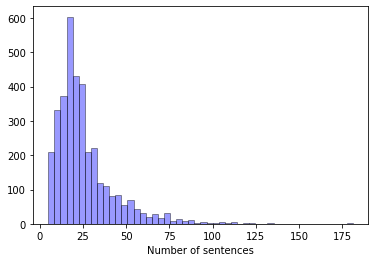

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.distplot(SurgPath_df_analysis['Number of sentences'], hist=True, kde=False, 
             color = 'blue',
             hist_kws={'edgecolor':'black'});

### Converting the note_texts to lower case

In [22]:
SurgPath_df_analysis['note_text'] = SurgPath_df_analysis['note_text'].apply(lambda x: x.lower())

### Check with QUICKUMLS output for any useful concept from these notes containing only one sentence

In [25]:
SurgPath_df_analysis =SurgPath_df_analysis.assign(**{'T023 output': np.nan, 'T191 output': np.nan})
SurgPath_df_analysis.reset_index(inplace= True)


### To check if concept extraction is useful from semstring 

In [26]:
corpus_T023_total = []
corpus_T191_total = []
for i in range(len(SurgPath_df_analysis.index)):
    
    text = SurgPath_df_analysis.iloc[i].nlp_text_qu_ner
    d = ast.literal_eval(text)
    Testframe = pd.DataFrame.from_dict(d)
    corpus_T023 = Testframe[Testframe['semtypestring'] == 'T023']['ngram'].tolist()
    corpus_T191 = Testframe[Testframe['semtypestring'] == 'T191']['ngram'].tolist()
    corpus_T023_total.append(corpus_T023)
    corpus_T191_total.append(corpus_T191)
    
    

### Only few are empty
### 2.59% for T023
### 2.87 % for T191
## It appears that Surgpath reports are carrying more information than RadPath report on average

In [32]:
corpus_T023_total
T023 = [e for e in corpus_T023_total if e]
print(100*(1- (len(T023)/len(corpus_T023_total))))

T191 = [e for e in corpus_T191_total if e]
print(100*(1- (len(T191)/len(corpus_T191_total))))

2.590819487468321
2.8724303013235697


In [ ]:
# RadPath_analysis.groupby([['pat_id','result_time','note_text', 'Number of sentences','Longest sentence length',\
#                                'Shortest sentence length', 'average sentence length']])
SurgPath_df_analysis.groupby(['pat_id','result_time']).size()

### word2vec model from the words in the sentences
### word vectorization with TFIDF

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_TFIDF = TfidfVectorizer()
vectorizer_CV = CountVectorizer()


In [35]:
text_cohort =[]
for i in range(len(SurgPath_df_analysis.index)):
    text = SurgPath_df_analysis.loc[i,'note_text']
    text_cohort.append(text)
#     word_input = word_tokenize(text)
    
    
    
#     text_CV= vectorizer_CV.fit_transform(word_input)
#     text_TFIDF = vectorizer_TFIDF.fit_transform(word_input)

### Use TFIDF method to find out the words that has propotional representation in he corpus

In [36]:
text_CV= vectorizer_CV.fit_transform(text_cohort)
text_TFIDF = vectorizer_TFIDF.fit_transform(text_cohort)

In [37]:
vectorizer_CV.get_feature_names()[np.sum(text_CV.toarray(),axis =0).argmax()]
vectorizer_TFIDF.get_feature_names()[np.sum(text_TFIDF.toarray(),axis =0).argmax()]

'the'

In [ ]:
np.sum(text_TFIDF.toarray(),axis =0)
#np.sum(text_CV.toarray(),axis =0)
# vectorizer_TFIDF.get_feature_names()[np.sum(text_TFIDF.toarray(),axis =0).argmin()]

### Implement word2vec on th text cohort from the single sentence sets

In [44]:
text_cohort
all_words = [nltk.word_tokenize(sent) for sent in text_cohort]
# Removing Stop Words
from nltk.corpus import stopwords
for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]

In [40]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(all_words, min_count=5)

In [ ]:
vocabulary = word2vec_model.wv.vocab
print(vocabulary)

In [ ]:
v1 = word2vec_model.wv['test']
v1

In [42]:
f_name = 'wor2vec_model.txt'
word2vec_model.wv.save_word2vec_format(f_name, binary = False)

/home/dbasu/.local/share/virtualenvs/ucd-ri-csnlp-AG0bO8yr/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Implement doc2vec on the sentences

In [54]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [ ]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

In [47]:
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [48]:
train_corpus = list(read_corpus(lee_train_file))
test_corpus = list(read_corpus(lee_test_file, tokens_only=True))

In [50]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)


In [51]:
model.build_vocab(train_corpus)


In [52]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 4.34 s, sys: 135 ms, total: 4.48 s
Wall time: 1.91 s


# Using SpaCy 

In [ ]:
RadSenLen =[]
for i in RadPath_df.index:
    text =RadPath_df.loc[i]['note_text']
    doc = nlp(text)
    RadSenLen.append(len(doc))

In [ ]:
#Return the indices of rows with number of sentences equal to 1
res_list = list(filter(lambda x: RadSenLen[x] == 3, range(len(RadSenLen)))) 

In [ ]:
import random
i = random.choice(res_list)
print(i)
text =RadPath_df.iloc[i]['note_text']
doc = nlp(text)
for i, token in enumerate(doc):
    print('-->Sentence %d: %s' % (i, token))